# Initialisation
Import des packages utile

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Analyse des données
On commence par importer les données depuis un fichier CSV

In [37]:
d = pd.read_csv('SensorTile_Log_N007.csv')
d.columns

Index(['T [ms]', 'AccX [mg]', 'AccY [mg]', 'AccZ [mg]', 'GyroX [mdps]',
       'GyroY [mdps]', 'GyroZ [mdps]'],
      dtype='object')

In [38]:
def cleanDataframe(df):
    df = df.drop(columns=["T [ms]"])
    return df

def sliceDf(df, step):
    res = []
    while (len(df) > step):
        res.append(df.iloc[:step])
        df = df.iloc[step:]
    return res

In [46]:
d = cleanDataframe(d)
d.tail(10)

,AccX [mg],AccY [mg],AccZ [mg],GyroX [mdps],GyroY [mdps],GyroZ [mdps]
813,-108,1126,-267,-140,-109970,-167370
814,-105,1112,-268,-18480,-112560,-168000
815,-108,1102,-268,-35700,-108010,-157640
816,-112,1122,-269,-39620,-103110,-152950
817,-108,1111,-263,-34930,-102690,-160720
818,-98,1042,-247,-36890,-104370,-171010
819,-89,992,-244,-51800,-100520,-168490
820,-84,976,-245,-66920,-86380,-148610
821,1998,1997,1373,-66850,-63350,-118160
822,-1987,354,1722,-17500,417480,-326620


In [40]:
dfs = sliceDf(d, 100)
len(d)

823

In [41]:
len(dfs)

8

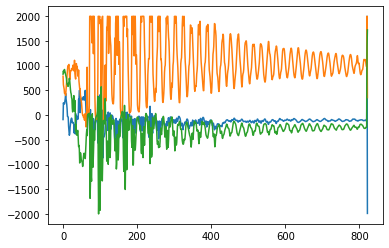

In [42]:
plt.plot(d["AccX [mg]"])
plt.plot(d["AccY [mg]"])
plt.plot(d["AccZ [mg]"])

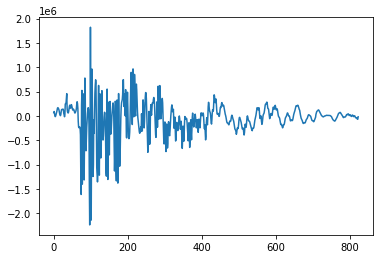

In [43]:
plt.plot(d["GyroX [mdps]"])